# Emotion Recognition using a CNN model with integrated heatmap/prioritised convolution operation

Importing the libraries I will be using

In [1]:
# Imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import tensorflow as tf

# Define emotion labels
EMOTION_LABELS = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Data Preprocessor
class DataPreprocessor:
    """
    Handles loading, preprocessing, and splitting the FER2013 dataset.
    """

    def __init__(self, dataset_path="fer2013_data"):
        self.dataset_path = dataset_path
        self.train_data = None
        self.train_labels = None
        self.val_data = None
        self.val_labels = None
        self.test_data = None
        self.test_labels = None

    def load_data_from_folder(self, folder_path):
        """
        Load images and their corresponding labels from a folder structure.
        Each subfolder name is treated as the label.
        """
        data = []
        labels = []

        for label, emotion_dir in enumerate(os.listdir(folder_path)):
            emotion_folder = os.path.join(folder_path, emotion_dir)

            if os.path.isdir(emotion_folder):
                for image_file in os.listdir(emotion_folder):
                    image_path = os.path.join(emotion_folder, image_file)

                    try:
                        # Load the image and convert it to an array
                        img = load_img(image_path, target_size=(48, 48), color_mode="grayscale")
                        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
                        data.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

        return np.array(data), np.array(labels)

    def preprocess_data(self):
        """
        Preprocess the data: load train/test folders and split train into train/validation sets.
        """
        # Load train and test data
        train_folder = os.path.join(self.dataset_path, "train")
        test_folder = os.path.join(self.dataset_path, "test")

        train_data, train_labels = self.load_data_from_folder(train_folder)
        test_data, test_labels = self.load_data_from_folder(test_folder)

        # Display a sample image and its label
        self.display_sample(train_data, train_labels, "Train")

        # Split train data into train/validation sets
        X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

        # Convert labels to one-hot encoding
        num_classes = len(np.unique(train_labels))
        y_train = to_categorical(y_train, num_classes)
        y_val = to_categorical(y_val, num_classes)
        y_test = to_categorical(test_labels, num_classes)

        self.train_data, self.train_labels = X_train, y_train
        self.val_data, self.val_labels = X_val, y_val
        self.test_data, self.test_labels = test_data, y_test

    def display_sample(self, data, labels, dataset_name="Dataset"):
        """
        Display a random sample image and its corresponding label.
        """
        index = np.random.randint(len(data))
        sample_image = data[index]
        sample_label = labels[index]

        plt.imshow(sample_image.squeeze(), cmap="gray")
        plt.title(f"{dataset_name} Sample - Label: {EMOTION_LABELS[np.argmax(sample_label)]}")
        plt.axis("off")
        plt.show()

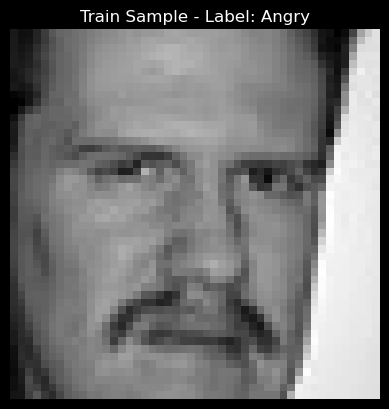

In [3]:
# Example usage
dataset_path = "fer2013_data"
preprocessor = DataPreprocessor(dataset_path)
preprocessor.preprocess_data()

In [4]:
# Custom Convolutional Layer
class SpiralConv2D(layers.Layer):
    """
    Custom convolutional layer that applies a kernel in a spiral pattern.
    """
    def __init__(self, filters, kernel_size, activation=None, **kwargs):
        super(SpiralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = layers.Activation(activation) if activation else None

    def build(self, input_shape):
        # Initialize the kernel and bias for the convolution
        self.kernel = self.add_weight(
            shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel"
        )
        self.bias = self.add_weight(
            shape=(self.filters,),
            initializer="zeros",
            trainable=True,
            name="bias"
        )

        # Precompute spiral indices for the input dimensions
        height, width = input_shape[1], input_shape[2]
        self.spiral_indices = tf.constant(self.generate_spiral_indices(height, width), dtype=tf.int32)

    def call(self, inputs):
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding="SAME"
        )
        print(f"Patches shape: {patches.shape}")

        batch_size = tf.shape(inputs)[0]
        height, width = tf.shape(inputs)[1], tf.shape(inputs)[2]
        depth = tf.shape(inputs)[-1]

        patches = tf.reshape(patches, [batch_size, height * width, self.kernel_size, self.kernel_size, depth])
        print(f"Reshaped patches shape: {patches.shape}")

        spiral_patches = tf.gather(patches, self.spiral_indices, axis=1)
        print(f"Spiral patches shape: {spiral_patches.shape}")

        conv_result = tf.einsum("bijlm,klmn->bijn", spiral_patches, self.kernel)
        print(f"Convolution result shape: {conv_result.shape}")

        conv_result = tf.nn.bias_add(conv_result, self.bias)

        if self.activation:
            conv_result = self.activation(conv_result)

        outputs = tf.reshape(conv_result, [batch_size, height, width, self.filters])
        return outputs

    def generate_spiral_indices(self, height, width):
        spiral_indices = []
        visited = np.zeros((height, width), dtype=bool)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        x, y, direction_idx = 0, 0, 0

        for _ in range(height * width):
            if 0 <= x < height and 0 <= y < width and not visited[x, y]:
                spiral_indices.append(x * width + y)  # Flattened index
                visited[x, y] = True
            else:
                # Reverse the last step and change direction
                x -= directions[direction_idx][0]
                y -= directions[direction_idx][1]
                direction_idx = (direction_idx + 1) % 4

            x += directions[direction_idx][0]
            y += directions[direction_idx][1]

        return spiral_indices

In [5]:
# EmotionCNN class
class EmotionCNN:
    """
    Defines the CNN model for emotion detection and handles training, evaluation, and saving/loading of the model.
    """

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def build_model(self):
        # Ensure input_shape is passed correctly to the first layer
        self.model = models.Sequential([
            SpiralConv2D(filters=32, kernel_size=3, activation="relu", input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            SpiralConv2D(filters=64, kernel_size=3, activation="relu"),
            layers.MaxPooling2D((2, 2)),
            SpiralConv2D(filters=128, kernel_size=3, activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(self.num_classes, activation="softmax"),
        ])

        # Print layer names and output shapes for debugging
        print("Model layers and output shapes:")
        for layer in self.model.layers:
            print(f"Layer Name: {layer.name}, Output Shape: {layer.output_shape}")

    def compile_model(self):
        self.model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    def train_model(self, train_data, train_labels, val_data, val_labels, epochs):
        history = self.model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=epochs)
        return history

    def evaluate_model(self, test_data, test_labels):
        loss, accuracy = self.model.evaluate(test_data, test_labels)
        print(f"Test Accuracy: {accuracy:.2f}")
        return accuracy

    def predict_emotion(self, input_image):
        prediction = self.model.predict(np.expand_dims(input_image, axis=0))
        return np.argmax(prediction)

    def save_model(self, file_path):
        """Save the trained model to the specified file path."""
        if self.model:
            self.model.save(file_path)
            print(f"Model saved to {file_path}")
        else:
            print("Model has not been built or trained yet.")

    def load_model(self, file_path):
        """Load a trained model from the specified file path."""
        self.model = models.load_model(file_path)
        print(f"Model loaded from {file_path}")

In [6]:
# Heatmap generation
class HeatmapGenerator:
    """
    Generates and visualizes heatmaps using Class Activation Maps (CAMs).
    """

    def __init__(self, model):
        self.model = model

    def compute_gradients(self, input_image, predicted_class):
        # Use the index of the last convolutional layer (-4 in this case)
        last_conv_layer = self.model.layers[-4]  # Adjust the index if the model changes

        grad_model = tf.keras.models.Model(
            [self.model.inputs], [last_conv_layer.output, self.model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(np.expand_dims(input_image, axis=0))
            loss = predictions[:, predicted_class]

        grads = tape.gradient(loss, conv_outputs)
        return conv_outputs, grads

    def generate_heatmap(self, conv_outputs, grads):
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]  # Remove batch dimension
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)  # Set negative values to 0
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)  # Normalize to range [0, 1]
        return heatmap

    def visualize_heatmap(self, input_image, heatmap, predicted_label, true_label):
        """
        Overlay the heatmap on the input image with a blue-to-red colormap.
        """
        # Normalize heatmap for the color range
        norm = Normalize(vmin=0, vmax=1)
        
        # Create a figure
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Show the input image
        ax[0].imshow(input_image.squeeze(), cmap="gray")
        ax[0].set_title(f"Input Image\nTrue Label: {true_label}\nPredicted: {predicted_label}")
        ax[0].axis("off")

        # Overlay the heatmap
        heatmap_colored = plt.cm.coolwarm(norm(heatmap))  # Use the blue-to-red colormap
        ax[1].imshow(input_image.squeeze(), cmap="gray")
        ax[1].imshow(heatmap_colored, alpha=0.5)  # Overlay with transparency
        ax[1].set_title("Heatmap Overlay")
        ax[1].axis("off")

        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="coolwarm"), ax=ax[1], orientation="vertical")
        plt.tight_layout()
        plt.show()

In [7]:
# Emotion detection system
class EmotionDetectionSystem:
    """
    Main class that orchestrates the entire process: preprocessing, training, and heatmap generation.
    """

    def __init__(self, dataset_path, input_shape, num_classes, model_path="models/emotion_custom_cnn.h5"):
        self.dataset_path = dataset_path
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_path = model_path
        self.data_preprocessor = DataPreprocessor(dataset_path)
        self.emotion_cnn = EmotionCNN(input_shape, num_classes)
        self.heatmap_generator = None

    def run(self):
        # Load and preprocess the dataset
        self.data_preprocessor.preprocess_data()

        # Check if the model exists at the specified path
        if os.path.exists(self.model_path):
            # Load the pre-trained model
            print(f"Loading saved model from {self.model_path}...")
            self.emotion_cnn.load_model(self.model_path)
        else:
            # Create and train a new model if it doesn't exist
            print(f"No model found at {self.model_path}. Creating and training a new model...")
            self.emotion_cnn.build_model()
            self.emotion_cnn.compile_model()
            self.emotion_cnn.train_model(
                self.data_preprocessor.train_data,
                self.data_preprocessor.train_labels,
                self.data_preprocessor.val_data,
                self.data_preprocessor.val_labels,
                epochs=10,
            )
            # Save the trained model
            self.emotion_cnn.save_model(self.model_path)

        # Evaluate the model on the test set
        print("Evaluating the model on the test dataset...")
        if hasattr(self.data_preprocessor, "test_data"):
            self.emotion_cnn.evaluate_model(self.data_preprocessor.test_data, self.data_preprocessor.test_labels)

        # Generate and visualize heatmaps
        print("Generating and visualizing heatmaps...")
        self.heatmap_generator = HeatmapGenerator(self.emotion_cnn.model)
        for i in range(3):  # Visualize for the first 3 test samples
            input_image = self.data_preprocessor.test_data[i]
            true_label = np.argmax(self.data_preprocessor.test_labels[i])  # True label
            predicted_class = self.emotion_cnn.predict_emotion(input_image)

            conv_outputs, grads = self.heatmap_generator.compute_gradients(input_image, predicted_class)
            heatmap = self.heatmap_generator.generate_heatmap(conv_outputs, grads)

            self.heatmap_generator.visualize_heatmap(
                input_image, heatmap, predicted_label=predicted_class, true_label=true_label
            )

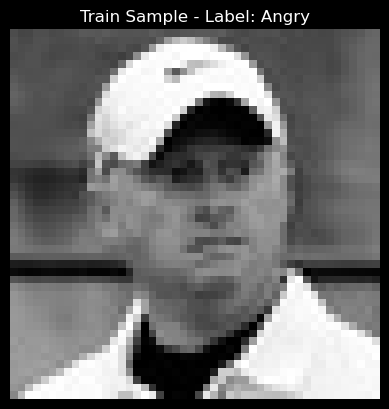

No model found at models/emotion_custom_cnn.h5. Creating and training a new model...
Patches shape: (None, 48, 48, 9)
Reshaped patches shape: (None, 2304, 3, 3, 1)
Spiral patches shape: (None, 2226, 3, 3, 1)
Convolution result shape: (None, 2226, 3, 32)
Patches shape: (None, 24, 24, 288)
Reshaped patches shape: (None, 576, 3, 3, 32)
Spiral patches shape: (None, 540, 3, 3, 32)
Convolution result shape: (None, 540, 3, 64)
Patches shape: (None, 12, 12, 576)
Reshaped patches shape: (None, 144, 3, 3, 64)
Spiral patches shape: (None, 128, 3, 3, 64)
Convolution result shape: (None, 128, 3, 128)
Model layers and output shapes:
Layer Name: spiral_conv2d, Output Shape: (None, 48, 48, 32)
Layer Name: max_pooling2d, Output Shape: (None, 24, 24, 32)
Layer Name: spiral_conv2d_1, Output Shape: (None, 24, 24, 64)
Layer Name: max_pooling2d_1, Output Shape: (None, 12, 12, 64)
Layer Name: spiral_conv2d_2, Output Shape: (None, 12, 12, 128)
Layer Name: max_pooling2d_2, Output Shape: (None, 6, 6, 128)
Layer

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/spiral_conv2d/Reshape_1' defined at (most recent call last):
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\1357086569.py", line 6, in <module>
      emotion_system.run()
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\3277853973.py", line 30, in run
      self.emotion_cnn.train_model(
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\2345869713.py", line 35, in train_model
      history = self.model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=epochs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\3083889868.py", line 59, in call
      outputs = tf.reshape(conv_result, [batch_size, height, width, self.filters])
Node: 'sequential/spiral_conv2d/Reshape_1'
Detected at node 'sequential/spiral_conv2d/Reshape_1' defined at (most recent call last):
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\1357086569.py", line 6, in <module>
      emotion_system.run()
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\3277853973.py", line 30, in run
      self.emotion_cnn.train_model(
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\2345869713.py", line 35, in train_model
      history = self.model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=epochs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_14700\3083889868.py", line 59, in call
      outputs = tf.reshape(conv_result, [batch_size, height, width, self.filters])
Node: 'sequential/spiral_conv2d/Reshape_1'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input to reshape is a tensor with 6838272 values, but the requested shape has 2359296
	 [[{{node sequential/spiral_conv2d/Reshape_1}}]]
	 [[gradient_tape/sequential/spiral_conv2d_2/Reshape_4/_60]]
  (1) INVALID_ARGUMENT:  Input to reshape is a tensor with 6838272 values, but the requested shape has 2359296
	 [[{{node sequential/spiral_conv2d/Reshape_1}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1893]

In [8]:
# Run the system
dataset_path = "fer2013_data"
input_shape = (48, 48, 1)
num_classes = 7
emotion_system = EmotionDetectionSystem(dataset_path, input_shape, num_classes)
emotion_system.run()